# Quantum Implementation of a Binary Valued Perceptron
## Group Members
- Ghani Haider 
- Neha Mumtaz Jafry 

A detailed report about the explanation and implementation of the paper and generated results is submitted with this jupyter file. This script is the implementation of the proposed algorithm by [Tacchino et al](https://www.nature.com/articles/s41534-019-0140-4) for a quantum binary perceptron. We are implementing the quantum solution for $2^3$-dimension input and weight vector. However, the written solution can work with any $2^n$-dimension vectors. We are also simulating the circuit on both ideal and noisy models.

## Structure of a Quantum Peceptron
Similar to the classical perceptron, the quantum binary perceptron also has m-dimensional $\vec{i}$ input
and $\vec{w}$ weight vectors where $\vec{i_j}$, $\vec{w_j} \in \{−1,1\}$. These
vectors are encoded on an N-qubit quantum hardware, where $N = log_2(m)$. The figure below shows the structure of the quantum perceptron. As we can see, instead of the linear combination in a classical
neuron, the input vector goes through two unitary transformations using the $Ui$ and $Uw$ blocks,
which each utilize the input and weight vector respectively. Then using a multi-controlled NOT
gate, which serves as the activation function, we measure the output of the neuron on the ancilla
qubit.

[![oRnPBh.jpg](https://i.im.ge/2021/12/04/oRnPBh.jpg)](https://im.ge/i/oRnPBh)

### In order to implement the algorithm, we will first introduce the Sign-Flip Blocks.

In [1]:
from qiskit import QuantumCircuit,execute,Aer,IBMQ
from qiskit.providers.aer.noise import NoiseModel
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

# Sign-Flip Blocks
Assume we have a 8-dimension input vector given as $\vec{i}$ = (-1, 1, 1, 1, 1, 1, 1, 1). It can be represented as
| $\vec{i_j}$ | val |
| :-: |:-: |
|000|-1|
|001|1|
|010|1|
|011|1|
|100|1|
|101|1|
|110|1|
|111|1|


So the number of qubits required to represent the input vector is $log_2(m) = log_2(8) = 3$. In order to encode the vector values (-1,1) into the qubits, we can generate the super-positions of the qubits using Hadamard gates which will give
$$|000\rangle => |000\rangle + |001\rangle + |010\rangle+ |011\rangle + |100\rangle + |101\rangle + |110\rangle+ |111\rangle$$
We can then use an ancila qubit in the state $|-\rangle$ and apply multi-control CNOT gate on it to introduce $-1$ infront of the superposition where $\vec{i_j} = -1$.
In the given case, we have $-1$ in the input vector at $j = 000$ or $0$ in decimal notation. We define a Sign-Flip block $SF_{3, 0}$ such that it would apply X gate on the 3-qubits where each qubit is in $|0\rangle$ state. Once the $|0\rangle$ state qubits are flipped, all 3-qubits are in $|1\rangle$ state thus the CNOT gate is applied on the ancila qubit in $|-\rangle$ state which would yield a negative sign.
$$|-\rangle = |0\rangle - |1\rangle$$
apply CNOT gate
$$|0\rangle - |1\rangle => |1\rangle - |0\rangle = -(|0\rangle - |1\rangle)$$

In [2]:
# A single Sign Flip Block
def SF(nqubits, j, displays=False):
    qcSF = QuantumCircuit(nqubits+1)
    binj = bin(j)[2:].rjust(nqubits,'0')

    # apply X gate on qubits
    for (i,s) in zip(range(nqubits),binj):
            if s == '0':
                qcSF.x(i) 

    # MCT to flip the sign
    lst = [j for j in range(nqubits)]
    qcSF.mct(lst, nqubits)

    # reverse the X gate on qubits
    for (i,s) in zip(range(nqubits),binj):
            if s == '0':
                qcSF.x(i) 

    qcSF.barrier()

    # draw the circuit
    if displays:
        display(qcSF.draw())

    return qcSF

In [12]:
# example of a circuit with three qubits and SF block for position 000
circuit = SF(3, 0, True)

┌───┐     ┌───┐ ░ 
q_0: ┤ X ├──■──┤ X ├─░─
     ├───┤  │  ├───┤ ░ 
q_1: ┤ X ├──■──┤ X ├─░─
     ├───┤  │  ├───┤ ░ 
q_2: ┤ X ├──■──┤ X ├─░─
     └───┘┌─┴─┐└───┘ ░ 
q_3: ─────┤ X ├──────░─
          └───┘      ░

# Algorithm Implementation
## The steps to implement the general algorithm for the quantum perceptron is given as:
1. Create a quantum circuit with N-qubits and an ancila qubit in $|0\rangle$ state given $2^N$ dimension $\vec{i}$ input and $\vec{w}$ weight vectors.
2. Initialize the ancila qubit in $|-\rangle$ state by appyling X gate followed by a Hadamard gate.
3. Apply $U_i$ transformation by first applying parallel Hadamard gates, creating equal super-position of all the elements of the computational basis and then encoding values of input vector $\vec{i}$ by applying $SF_{N, j}$ blocks wherever $\vec{i_j} = -1$. The result is state $|\psi_i\rangle$.
4. Similarly, apply $U_w$ transformation using weight vector $\vec{w}$. The result is state $|\psi_w\rangle$ on which parallel Hadamard gates are applied again follow by NOT gates to get the desired $|11...1\rangle$ state.
5. Set the ancila qubit in $|0\rangle$ state by appyling Hamdamard gate followed by a X gate.
6. Measure the output on the ancila qubit.

In [4]:

def QuantumNeuron(i, weight, displays=False, noise=False):
    nqubits = int(np.log2(len(i)))

    qcphii = QuantumCircuit(nqubits + 1, 1)#ancilla added

    # adding the hadamard gates
    for j in range(nqubits):    
        qcphii.h(j)
    # add not and h for the ancilla qubit
    qcphii.x(-1)
    qcphii.h(-1)
    qcphii.barrier()

    ### U_i transormation ###
    # implementing sign flip blocks for vector i
    for j in range(2**(nqubits)):
        if i[j] == -1:
            SFN_j = SF(nqubits,j)
            qcphii.compose(SFN_j, inplace=True)

    ### U_w transormation ###
    # implementing sign flip blocks for vector w
    for j in range(2**(nqubits)):
        if weight[j] == -1:
            SFN_j = SF(nqubits,j)
            qcphii.compose(SFN_j, inplace=True)

    # reverse hadamard gates
    for j in range(nqubits):    
        qcphii.h(j)
    # add not and h for ancilla
    qcphii.h(-1)
    qcphii.x(-1)
    qcphii.barrier()

    # not gates on the qubits to obtain state |111...1>
    for j in range(nqubits):    
        qcphii.x(j)

    # MCT on the ancilla to measure
    lst = [j for j in range(nqubits)]
    qcphii.mct(lst, nqubits)

    # measure values
    qcphii.measure(nqubits, 0)

    # draw the circuit
    if displays:
        display(qcphii.draw())

    # # simulate the circuit
    if noise == False:
        job = execute(qcphii,Aer.get_backend('qasm_simulator'),shots=8192)
        counts = job.result().get_counts(0)

    if noise == True:
        result = execute(qcphii, Aer.get_backend('qasm_simulator'),
                        coupling_map=coupling_map,
                        basis_gates=basis_gates,
                        noise_model=noise_model,
                        shots=8192).result()
        counts = result.get_counts(0)

    return counts    

In [5]:
i = [-1,1,1,1,1,1,1,1]
w = [-1,1,1,1,1,1,1,1]

QuantumNeuron(i, w, displays=True)

┌───┐      ░ ┌───┐     ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐      ░ ┌───┐     »
q_0: ┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░─┤ H ├──────░─┤ X ├──■──»
     ├───┤      ░ ├───┤  │  ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤      ░ ├───┤  │  »
q_1: ┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░─┤ H ├──────░─┤ X ├──■──»
     ├───┤      ░ ├───┤  │  ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤      ░ ├───┤  │  »
q_2: ┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░─┤ H ├──────░─┤ X ├──■──»
     ├───┤┌───┐ ░ └───┘┌─┴─┐└───┘ ░ └───┘┌─┴─┐└───┘ ░ ├───┤┌───┐ ░ └───┘┌─┴─┐»
q_3: ┤ X ├┤ H ├─░──────┤ X ├──────░──────┤ X ├──────░─┤ H ├┤ X ├─░──────┤ X ├»
     └───┘└───┘ ░      └───┘      ░      └───┘      ░ └───┘└───┘ ░      └───┘»
c: 1/════════════════════════════════════════════════════════════════════════»
                                                                             »
«        
«q_0: ───
«        
«q_1: ───
«        
«q_2: ───
«     ┌─┐
«q_3: ┤M├
«     └╥┘
«c: 1/═╩═
«      0

{'1': 8192}

# Generating all possible input vector patterns

We have chosen $2^3$-dimensional input and weight vectors $\vec{i}$, $\vec{w}$. We are fixing $\vec{w}$ and
running all $256$ possible patterns of $\vec{i}$ on it.
The $\vec{i}$ input vector patterns are generated in such way that initially, we have all $\vec{i_j} \in \{1\}$ and then we incrementally set some $\vec{i_j} = −1$ at different positions, finally having all $\vec{i_j} \in \{-1\}$.

In [6]:
# get all the combinations of input vector i of 8-dimension = 2^8 = 256

# to generate all combinations of a vector
def binary_combinations(lst):
    for comb in combinations(range(len(lst)), lst.count(1)):
        result = [-1] * len(lst)
        for i in comb:
            result[i] = 1
        yield result

# to save all the input patterns
possibleInputs = []
# 9 basic input vector i of 8-dimension with different -1 values
i_lst = [[1, 1, 1, 1, 1, 1, 1, 1], [-1, 1, 1, 1, 1, 1, 1, 1], [-1, -1, 1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1, 1, 1], 
        [-1, -1, -1, -1, 1, 1, 1, 1], [-1, -1, -1, -1, -1, 1, 1, 1], [-1, -1, -1, -1, -1, -1, 1, 1],
        [-1, -1, -1, -1, -1, -1, -1, 1], [-1, -1, -1, -1, -1, -1, -1, -1]]

for i in i_lst:
    for comb in binary_combinations(i):
        possibleInputs.append(comb)

print("Total possible pattern of the input vector : " + str(len(possibleInputs)))


Total possible pattern of the input vector : 256


# Ideal Simulation with all possible input vector patterns
We are simulating the circuit with all the generated input vectors and plotting the probability of the outcome 1, that is, the probability of ancila being $|1\rangle$, which indicates the activation of the perceptron. Below is the circuit simulation in an ideal case where there is no error in the measurement process as well as the gates.

In [7]:
### running the ideal circuit on all the input vectors ###

# save the output
ideal_graph_result = []

# fix weight vector
weight = [-1,1,1,1,1,1,1,-1]

for i in possibleInputs:
    result = QuantumNeuron(i, weight)
    # save the probability of the outcome 1
    if '1' in result.keys():
        ideal_graph_result.append((result['1'])/8192)
        # if i exaclty matches w, print it
        if result['1'] == 8192:
            print(i, result)
    elif '0' in result.keys():
        ideal_graph_result.append(0)

[-1, 1, 1, 1, 1, 1, 1, -1] {'1': 8192}
[1, -1, -1, -1, -1, -1, -1, 1] {'1': 8192}


## Plot the graph of ideal simulation

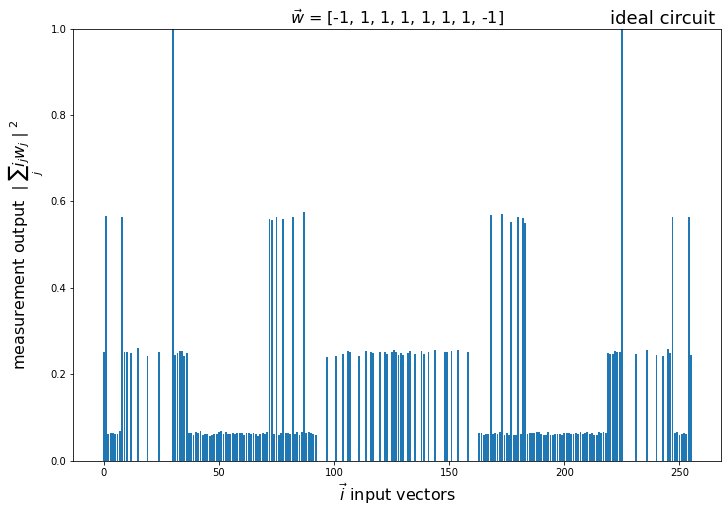

In [8]:
# plot bar graph of the measurement result of all input vectors

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
x_axis = [j for j in range(len(ideal_graph_result))]
ax.bar(x_axis, ideal_graph_result)
ax.set_ylim(0,1)
ax.set_xlabel(r'$\vec{i}$'+' input vectors', fontsize=16)
ax.set_ylabel('measurement output '+r'$\mid \sum_{j}i_jw_j \mid^2$', fontsize=16)
ax.text(220, 1.01, "ideal circuit", fontsize=18)
ax.set_title(r'$\vec{w}$'+ ' = ' +str(weight), fontsize=16)
plt.show()

# Noise Model Simulation
In order to replicate the circuit simulation on a real quantum processor where there is noise
associated with all processes in a quantum circuit (preparing the initial state, applying gates, and
qubit measurement), we are also simulating the noise of a quantum processors in Qiskit using
Noise Model Class and evaluating its performance with respect to the ideal simulation with no
noise. We used the available noise model for the ibmq manila real device backend from the IBMQ provider.

In [9]:
### Build noise model from backend properties ###

# uncomment the statement below to login for the first time using given account
# IBMQ.save_account('18c877753a27fe62e81fd7040287898dc8968802f7364f3176d9848ba03e2636ad99fc89f4756781b9f3ef311f39acb0bf487b45d269a34fecbc70e13d833119')
provider = IBMQ.load_account()
ibmq_backend = 'ibmq_manila'
backend = provider.get_backend(ibmq_backend)
# loading the noise model
noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates
print(noise_model)

### running the noise included circuit on all the input vectors ###
noise_graph_result = []

for i in possibleInputs:
    result = QuantumNeuron(i, weight, noise=True)
    # save the probability of the outcome 1
    if '1' in result.keys():
        noise_graph_result.append((result['1'])/8192)
        # if i exaclty matches w, print it
        if result['1'] == 8192:
            print(i, result)
    elif '0' in result.keys():
        noise_graph_result.append(0)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'reset', 'id', 'x', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


## Mean Squared Error - MSE
In order to give a quantitative measurement of the overall agreement between ideal and noise
included models, we are also calculating the mean squared error of the generated results between
them which is calculated below.

In [10]:
# calculating MSE

error = 0
# add error of all the simulations of input vectors
for i in range(len(possibleInputs)):
    error += (noise_graph_result[i] - ideal_graph_result[i])**2

mean_squared_error = round(error / len(possibleInputs), 3)
print(mean_squared_error)


0.086


## Plot the graph of noise simulation

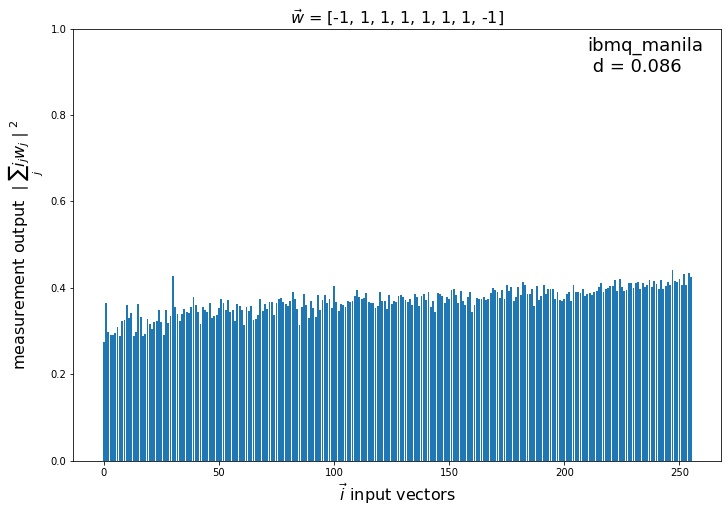

In [11]:
# plot bar graph of the measurement results with noise
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
x_axis = [j for j in range(len(noise_graph_result))]
ax.bar(x_axis, noise_graph_result)
ax.set_ylim(0,1)
ax.set_xlabel(r'$\vec{i}$'+' input vectors', fontsize=16)
ax.set_ylabel('measurement output '+ r'$\mid \sum_{j}i_jw_j \mid^2$', fontsize=16)
ax.text(210, 0.9, ibmq_backend + "\n d = " + str(mean_squared_error), fontsize=18)
ax.set_title(r'$\vec{w}$' + ' = ' + str(weight), fontsize=16)
plt.show()